In [1]:
# @title 1. Instalacja pakietów
!pip install lpips torchmetrics scikit-image opencv-python-headless tqdm matplotlib
!pip install flip-evaluator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.2/415.2 kB 29.7 MB/s eta 0:00:00


In [2]:
# @title 2. Przygotowanie Środowiska

import os
from datetime import datetime
import matplotlib.pyplot as plt
import json
import zipfile
import torch
from google.colab import drive

# ===============================================
# 1. Montaż dysku
# ===============================================
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')


# ===============================================
# 2. Rozpakowanie datasetu
# ===============================================
ZIP_PATH = '/content/drive/MyDrive/eiti/sigk/PROJ_3/dataset.zip'
EXTRACT_PATH = '/content/project_data'

if not os.path.exists(EXTRACT_PATH):
    print("Rozpakowywanie zbioru danych...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
    print("Gotowe.")
else:
    print("Dane już są rozpakowane.")

# ===============================================
# 3. Przygotowanie folderu na wyniki
# ===============================================
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
EXPERIMENT_NAME = f"NeuralRender_{timestamp}"
EXPERIMENT_DIR = f"/content/drive/MyDrive/eiti/sigk/PROJ_3/wyniki_{EXPERIMENT_NAME}"

os.makedirs(EXPERIMENT_DIR, exist_ok=True)
print(f"Wyniki będą zapisywane w: {EXPERIMENT_DIR}")


Mounted at /content/drive
Rozpakowywanie zbioru danych...
Gotowe.
Wyniki będą zapisywane w: /content/drive/MyDrive/eiti/sigk/PROJ_3/wyniki_NeuralRender_2025-12-01_18-27


In [5]:
# @title 3. Definicja Datasetu

import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import torchvision.transforms as T

class PhongDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.data = pd.read_csv(os.path.join(root_dir, csv_file))
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        img_path = os.path.join(self.root_dir, row['filename'])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        camera_pos_raw = torch.tensor([5.0, 5.0, 15.0])# Stała pozycja kamery
        obj_pos_raw = torch.tensor([row['obj_x'], row['obj_y'], row['obj_z']])
        dist = torch.norm(camera_pos_raw - obj_pos_raw)

        # INVERSE DEPTH (1 / odległosć od kamery)
        inv_dist = 1.0 / (dist + 1e-6)

        # normalizowane parametry
        obj_pos = obj_pos_raw / 20.0
        light_pos = torch.tensor([row['light_x'], row['light_y'], row['light_z']]) / 20.0
        diffuse = torch.tensor([row['diff_r'], row['diff_g'], row['diff_b']]) / 255.0
        shininess = torch.tensor([row['shininess']]) / 20.0
        rel_light = light_pos - obj_pos


        params = torch.cat([
            obj_pos,      # 3
            diffuse,      # 3
            shininess,    # 1
            light_pos,    # 3
            rel_light,    # 3
            inv_dist.unsqueeze(0) # 1
        ], dim=0).float()

        return params, image

def save_sample_image(gen_model, dataset, epoch, save_path):
  """
  Funkcja pomocnicza do zapisywania próbek wizualnych w trakcie treningu
  """
  gen_model.eval()
  with torch.no_grad():
      params, real_img = dataset[0]
      params = params.unsqueeze(0).to(device)

      fake_img = gen_model(params).detach().cpu().squeeze(0)

      fake_img = (fake_img + 1) / 2
      real_img = (real_img + 1) / 2

      fig, ax = plt.subplots(1, 2, figsize=(8, 4))
      ax[0].imshow(real_img.permute(1, 2, 0).clip(0, 1))
      ax[0].set_title("Ground Truth")
      ax[0].axis('off')

      ax[1].imshow(fake_img.permute(1, 2, 0).clip(0, 1))
      ax[1].set_title(f"Epoch {epoch}")
      ax[1].axis('off')

      plt.savefig(f"{save_path}/epoch_{epoch:03d}.png")
      plt.close()
  gen_model.train()

In [6]:
# @title 4. Definicja Dataloadera

transforms = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset_path = os.path.join(EXTRACT_PATH, 'dataset')
dataset = PhongDataset(dataset_path, 'metadata.csv', transform=transforms)

# Train/Test (80%/20%)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

print(f"Dane gotowe. Trening: {len(train_set)}, Test: {len(test_set)}")

Dane gotowe. Trening: 2400, Test: 600


In [7]:
# @title 5. Architektura cGAN
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, input_dim=14):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512 * 4 * 4),
            nn.BatchNorm1d(512 * 4 * 4),
            nn.ReLU(True)
        )

        self.conv = nn.Sequential(
            # 4x4 -> 8x8
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 8x8 -> 16x16
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 16x16 -> 32x32
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 32x32 -> 64x64
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # 64x64 -> 128x128
            nn.ConvTranspose2d(32, 3, 4, 2, 1, bias=False),
            nn.Tanh() # Wyjście [-1, 1]
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 512, 4, 4)
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim=14):
        super().__init__()
        self.img_layer = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
        ) # Output: 16x16

        self.param_layer = nn.Sequential(
            nn.Linear(input_dim, 16*16), nn.LeakyReLU(0.2)
        )

        self.final = nn.Sequential(
            nn.Conv2d(256+1, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, 8, 1, 0), nn.Sigmoid()
        )

    def forward(self, img, params):
        img_feat = self.img_layer(img)
        param_feat = self.param_layer(params).view(-1, 1, 16, 16)
        combined = torch.cat([img_feat, param_feat], dim=1)
        return self.final(combined).view(-1, 1).squeeze(1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG = Generator().to(device)
netD = Discriminator().to(device)
print("Modele zainicjalizowane.")

Modele zainicjalizowane.


In [8]:
# @title 6. Trening
import torch.optim as optim
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import time
import json


# ===============================================
# 1. Konfiguracja treningu
# ===============================================
optG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optD = optim.Adam(netD.parameters(), lr=0.0001, betas=(0.5, 0.999))

schedulerG = torch.optim.lr_scheduler.StepLR(optG, step_size=50, gamma=0.1)
schedulerD = torch.optim.lr_scheduler.StepLR(optD, step_size=50, gamma=0.1)

criterion_GAN = nn.BCELoss()
criterion_L1 = nn.L1Loss()

EPOCHS = 100
WARMUP_EPOCHS = 7
L1_LAMBDA = 400.0   # Wzysoka waga dla kolorów

history = {'G_loss': [], 'D_loss': []}

print(f"Start treningu: {EPOCHS} epok (Warmup: {WARMUP_EPOCHS})")
print("-" * 60)

start_time = time.time()

# ===============================================
# 2. Trening
# ===============================================
for epoch in range(EPOCHS):
    epoch_start = time.time()
    is_warmup = epoch < WARMUP_EPOCHS

    running_g_loss = 0.0
    running_d_loss = 0.0

    desc_text = f"Epoka {epoch+1}/{EPOCHS}" + (" [WARMUP]" if is_warmup else "")
    loop = tqdm(train_loader, leave=False, desc=desc_text)

    for i, (params, real_img) in enumerate(loop):
        params = params.to(device)
        real_img = real_img.to(device)

        batch_size = real_img.size(0)

        # ===============================================
        # 2.1. Trenowanie Dyskryminatora
        # ===============================================
        netD.zero_grad()

        if not is_warmup:
            label_real = torch.full((batch_size,), 0.9, device=device)
            label_fake = torch.zeros(batch_size, device=device)

            output_real = netD(real_img, params)
            loss_D_real = criterion_GAN(output_real, label_real)

            fake_img = netG(params)
            output_fake = netD(fake_img.detach(), params)
            loss_D_fake = criterion_GAN(output_fake, label_fake)

            loss_D = (loss_D_real + loss_D_fake) * 0.5
            loss_D.backward()
            optD.step()
        else:
            fake_img = netG(params)
            loss_D = torch.tensor(0.0, device=device)

        # ===============================================
        # 2.2. Trenowanie Generatora
        # ===============================================
        netG.zero_grad()

        if not is_warmup:
            output_fake_G = netD(fake_img, params)
            label_real_for_G = torch.ones(batch_size, device=device)

            loss_G_GAN = criterion_GAN(output_fake_G, label_real_for_G)
            loss_G_L1 = criterion_L1(fake_img, real_img) * L1_LAMBDA

            loss_G = loss_G_GAN + loss_G_L1
        else:
            loss_G_L1 = criterion_L1(fake_img, real_img) * L1_LAMBDA
            loss_G = loss_G_L1

        loss_G.backward()
        optG.step()

        running_d_loss += loss_D.item()
        running_g_loss += loss_G.item()
        loop.set_postfix(D=loss_D.item(), G=loss_G.item())

    # ===============================================
    # 2.3 KONIEC EPOKI
    # ===============================================
    schedulerG.step()
    schedulerD.step()

    avg_d = running_d_loss / len(train_loader)
    avg_g = running_g_loss / len(train_loader)

    history['G_loss'].append(avg_g)
    history['D_loss'].append(avg_d)

    status = "[WARMUP]" if is_warmup else ""
    print(f"Epoka [{epoch+1}/{EPOCHS}] {status} | Loss D: {avg_d:.4f} | Loss G: {avg_g:.4f}")

    save_sample_image(netG, test_set, epoch+1, EXPERIMENT_DIR)
    if (epoch + 1) % 10 == 0 or (epoch + 1) == EPOCHS:
        torch.save(netG.state_dict(), f"{EXPERIMENT_DIR}/generator_epoch_{epoch+1}.pth")
    with open(f"{EXPERIMENT_DIR}/loss_history.json", 'w') as f:
        json.dump(history, f)

print("-" * 60)
print("Trening zakończony.")

Start treningu: 100 epok (Warmup: 7)
------------------------------------------------------------


Epoka 1/100 [WARMUP]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [1/100] [WARMUP] | Loss D: 0.0000 | Loss G: 299.8783


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoka 2/100 [WARMUP]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [2/100] [WARMUP] | Loss D: 0.0000 | Loss G: 185.4220


Epoka 3/100 [WARMUP]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [3/100] [WARMUP] | Loss D: 0.0000 | Loss G: 118.4723


Epoka 4/100 [WARMUP]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [4/100] [WARMUP] | Loss D: 0.0000 | Loss G: 76.5592


Epoka 5/100 [WARMUP]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [5/100] [WARMUP] | Loss D: 0.0000 | Loss G: 48.3095


Epoka 6/100 [WARMUP]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [6/100] [WARMUP] | Loss D: 0.0000 | Loss G: 31.3269


Epoka 7/100 [WARMUP]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [7/100] [WARMUP] | Loss D: 0.0000 | Loss G: 22.1098


Epoka 8/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [8/100]  | Loss D: 0.3244 | Loss G: 22.5481


Epoka 9/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [9/100]  | Loss D: 0.3026 | Loss G: 19.9581


Epoka 10/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [10/100]  | Loss D: 0.2349 | Loss G: 17.9881


Epoka 11/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [11/100]  | Loss D: 0.2203 | Loss G: 16.7307


Epoka 12/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [12/100]  | Loss D: 0.2073 | Loss G: 15.7456


Epoka 13/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [13/100]  | Loss D: 0.2031 | Loss G: 15.0603


Epoka 14/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [14/100]  | Loss D: 0.1847 | Loss G: 14.4883


Epoka 15/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [15/100]  | Loss D: 0.1705 | Loss G: 14.7483


Epoka 16/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [16/100]  | Loss D: 0.1718 | Loss G: 14.7956


Epoka 17/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [17/100]  | Loss D: 0.1705 | Loss G: 14.7770


Epoka 18/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [18/100]  | Loss D: 0.2628 | Loss G: 13.7250


Epoka 19/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [19/100]  | Loss D: 0.2984 | Loss G: 12.0660


Epoka 20/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [20/100]  | Loss D: 0.2949 | Loss G: 11.8141


Epoka 21/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [21/100]  | Loss D: 0.1976 | Loss G: 12.7652


Epoka 22/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [22/100]  | Loss D: 0.1676 | Loss G: 11.8328


Epoka 23/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [23/100]  | Loss D: 0.1924 | Loss G: 11.4476


Epoka 24/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [24/100]  | Loss D: 0.1781 | Loss G: 11.1458


Epoka 25/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [25/100]  | Loss D: 0.1903 | Loss G: 11.4198


Epoka 26/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [26/100]  | Loss D: 0.2235 | Loss G: 11.8018


Epoka 27/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [27/100]  | Loss D: 0.1685 | Loss G: 10.7234


Epoka 28/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [28/100]  | Loss D: 0.2099 | Loss G: 11.4598


Epoka 29/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [29/100]  | Loss D: 0.3832 | Loss G: 9.1468


Epoka 30/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [30/100]  | Loss D: 0.5245 | Loss G: 8.0918


Epoka 31/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [31/100]  | Loss D: 0.5733 | Loss G: 6.1898


Epoka 32/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [32/100]  | Loss D: 0.3940 | Loss G: 7.1682


Epoka 33/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [33/100]  | Loss D: 0.4114 | Loss G: 8.0379


Epoka 34/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [34/100]  | Loss D: 0.4655 | Loss G: 7.0375


Epoka 35/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [35/100]  | Loss D: 0.5237 | Loss G: 6.5377


Epoka 36/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [36/100]  | Loss D: 0.4757 | Loss G: 6.1425


Epoka 37/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [37/100]  | Loss D: 0.5459 | Loss G: 5.7886


Epoka 38/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [38/100]  | Loss D: 0.4876 | Loss G: 5.7865


Epoka 39/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [39/100]  | Loss D: 0.5425 | Loss G: 5.3379


Epoka 40/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [40/100]  | Loss D: 0.5071 | Loss G: 5.3159


Epoka 41/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [41/100]  | Loss D: 0.5242 | Loss G: 5.2245


Epoka 42/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [42/100]  | Loss D: 0.5217 | Loss G: 5.2071


Epoka 43/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [43/100]  | Loss D: 0.5217 | Loss G: 5.1914


Epoka 44/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [44/100]  | Loss D: 0.4294 | Loss G: 5.0630


Epoka 45/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [45/100]  | Loss D: 0.4585 | Loss G: 5.3785


Epoka 46/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [46/100]  | Loss D: 0.5721 | Loss G: 5.1981


Epoka 47/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [47/100]  | Loss D: 0.4711 | Loss G: 5.0991


Epoka 48/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [48/100]  | Loss D: 0.4585 | Loss G: 5.0655


Epoka 49/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [49/100]  | Loss D: 0.4484 | Loss G: 4.9743


Epoka 50/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [50/100]  | Loss D: 0.4520 | Loss G: 5.0121


Epoka 51/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [51/100]  | Loss D: 0.3669 | Loss G: 4.5623


Epoka 52/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [52/100]  | Loss D: 0.3233 | Loss G: 4.4242


Epoka 53/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [53/100]  | Loss D: 0.3133 | Loss G: 4.4991


Epoka 54/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [54/100]  | Loss D: 0.3082 | Loss G: 4.4495


Epoka 55/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [55/100]  | Loss D: 0.3165 | Loss G: 4.4293


Epoka 56/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [56/100]  | Loss D: 0.3066 | Loss G: 4.4371


Epoka 57/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [57/100]  | Loss D: 0.3105 | Loss G: 4.4709


Epoka 58/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [58/100]  | Loss D: 0.3105 | Loss G: 4.4723


Epoka 59/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [59/100]  | Loss D: 0.3053 | Loss G: 4.4630


Epoka 60/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [60/100]  | Loss D: 0.3096 | Loss G: 4.4694


Epoka 61/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [61/100]  | Loss D: 0.3115 | Loss G: 4.4674


Epoka 62/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [62/100]  | Loss D: 0.3072 | Loss G: 4.4559


Epoka 63/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [63/100]  | Loss D: 0.3119 | Loss G: 4.4849


Epoka 64/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [64/100]  | Loss D: 0.3157 | Loss G: 4.4690


Epoka 65/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [65/100]  | Loss D: 0.3115 | Loss G: 4.4630


Epoka 66/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [66/100]  | Loss D: 0.3153 | Loss G: 4.5106


Epoka 67/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [67/100]  | Loss D: 0.3104 | Loss G: 4.4528


Epoka 68/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [68/100]  | Loss D: 0.3243 | Loss G: 4.5006


Epoka 69/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [69/100]  | Loss D: 0.3088 | Loss G: 4.4558


Epoka 70/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [70/100]  | Loss D: 0.3126 | Loss G: 4.4941


Epoka 71/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [71/100]  | Loss D: 0.3102 | Loss G: 4.5212


Epoka 72/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [72/100]  | Loss D: 0.3075 | Loss G: 4.6283


Epoka 73/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [73/100]  | Loss D: 0.3117 | Loss G: 4.5790


Epoka 74/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [74/100]  | Loss D: 0.2949 | Loss G: 4.6023


Epoka 75/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [75/100]  | Loss D: 0.3040 | Loss G: 4.6540


Epoka 76/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [76/100]  | Loss D: 0.2904 | Loss G: 4.5702


Epoka 77/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [77/100]  | Loss D: 0.3034 | Loss G: 4.5638


Epoka 78/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [78/100]  | Loss D: 0.3008 | Loss G: 4.5351


Epoka 79/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [79/100]  | Loss D: 0.2897 | Loss G: 4.5827


Epoka 80/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [80/100]  | Loss D: 0.2920 | Loss G: 4.6936


Epoka 81/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [81/100]  | Loss D: 0.2913 | Loss G: 4.5792


Epoka 82/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [82/100]  | Loss D: 0.2962 | Loss G: 4.6382


Epoka 83/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [83/100]  | Loss D: 0.3032 | Loss G: 4.6046


Epoka 84/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [84/100]  | Loss D: 0.3093 | Loss G: 4.5887


Epoka 85/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [85/100]  | Loss D: 0.3117 | Loss G: 4.5543


Epoka 86/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [86/100]  | Loss D: 0.2913 | Loss G: 4.6720


Epoka 87/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [87/100]  | Loss D: 0.2765 | Loss G: 4.6206


Epoka 88/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [88/100]  | Loss D: 0.2951 | Loss G: 4.6104


Epoka 89/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [89/100]  | Loss D: 0.2972 | Loss G: 4.5375


Epoka 90/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [90/100]  | Loss D: 0.2869 | Loss G: 4.6611


Epoka 91/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [91/100]  | Loss D: 0.2839 | Loss G: 4.6696


Epoka 92/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [92/100]  | Loss D: 0.2856 | Loss G: 4.5472


Epoka 93/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [93/100]  | Loss D: 0.2807 | Loss G: 4.6261


Epoka 94/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [94/100]  | Loss D: 0.2833 | Loss G: 4.6367


Epoka 95/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [95/100]  | Loss D: 0.2706 | Loss G: 4.6798


Epoka 96/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [96/100]  | Loss D: 0.2949 | Loss G: 4.6977


Epoka 97/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [97/100]  | Loss D: 0.2881 | Loss G: 4.6412


Epoka 98/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [98/100]  | Loss D: 0.2770 | Loss G: 4.6495


Epoka 99/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [99/100]  | Loss D: 0.2735 | Loss G: 4.6610


Epoka 100/100:   0%|          | 0/38 [00:00<?, ?it/s]

Epoka [100/100]  | Loss D: 0.2625 | Loss G: 4.8762
------------------------------------------------------------
Trening zakończony.


Obliczanie metryk na całym zbiorze testowym (LPIPS, SSIM, ALIP, Hausdorff)...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 206MB/s]


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth


  0%|          | 0/10 [00:00<?, ?it/s]

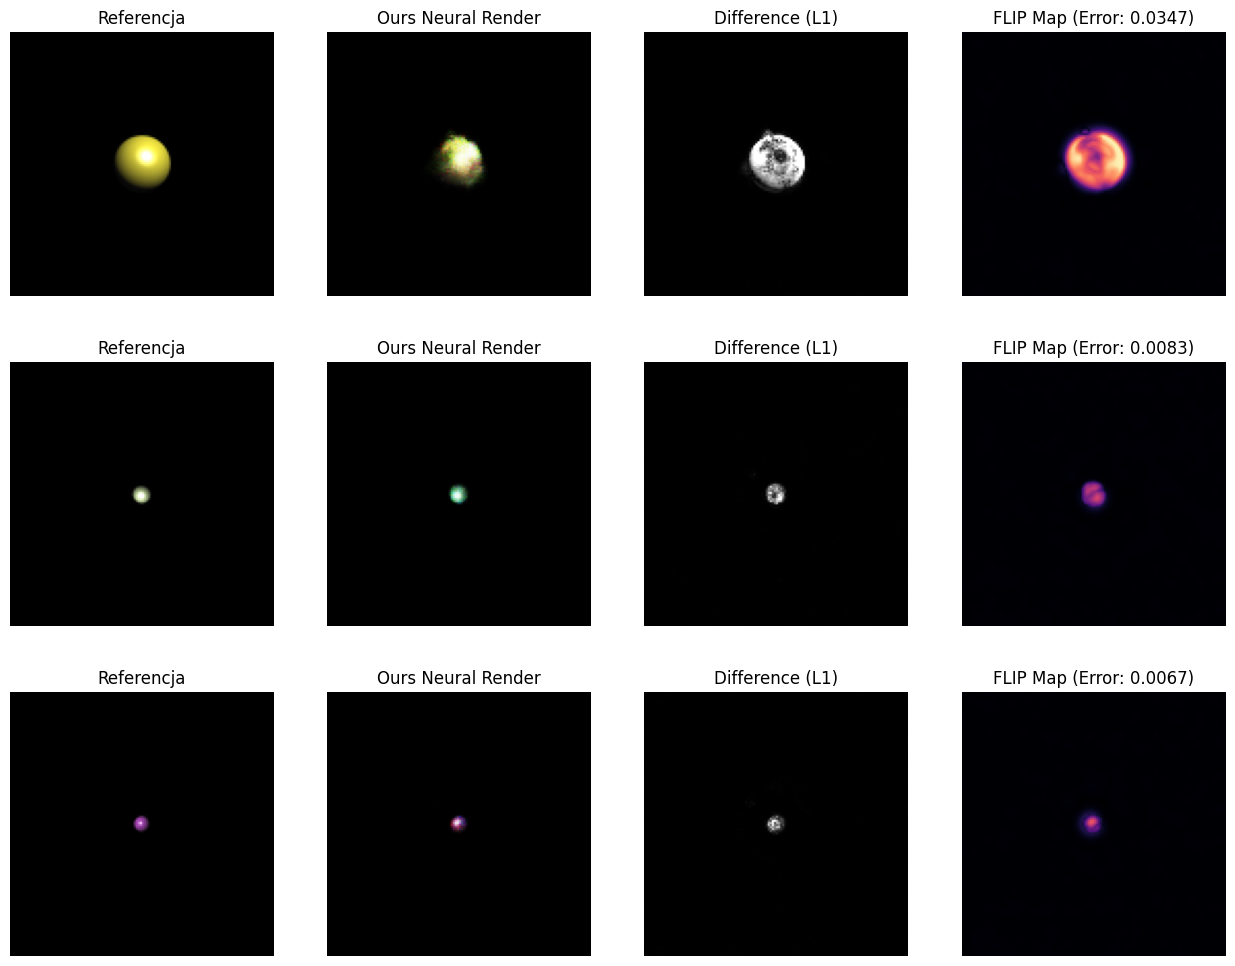


=== RAPORT KOŃCOWY ===
Eksperyment: NeuralRender_2025-12-01_18-27
Data: 2025-12-01 18:50
----------------------
METRYKI JAKOŚCI (zbiór testowy, N=600):

1. FLIP       : 0.015340

2. LPIPS      : 0.049749

3. SSIM       : 0.982261

4. Hausdorff  : 4.7485 px

Wizualizacja zapisana w:
/content/drive/MyDrive/eiti/sigk/PROJ_3/wyniki_NeuralRender_2025-12-01_18-27/wizualizacja_koncowa.png



In [9]:
# @title 4. Obliczanie Metryk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from scipy.spatial.distance import directed_hausdorff
import cv2
from tqdm.notebook import tqdm
import lpips
from torchmetrics.image import StructuralSimilarityIndexMeasure
from flip_evaluator import evaluate as flip_eval

# ===============================================
# 0. Funkcje pomocnicze
# ===============================================

def tensor_to_numpy_for_flip(tensor):
    """
    tensor PyTorch (C, H, W) [-1, 1] -> numpy array (H, W, C) [0, 1].
    """
    img_np = (tensor.permute(1, 2, 0).cpu().numpy() + 1.0) / 2.0
    return np.clip(img_np, 0, 1)

def calculate_hausdorff_metric(img_tensor_real, img_tensor_fake):
    real = (img_tensor_real.permute(1, 2, 0).cpu().numpy() * 127.5 + 127.5).astype(np.uint8)
    fake = (img_tensor_fake.permute(1, 2, 0).cpu().numpy() * 127.5 + 127.5).astype(np.uint8)

    edges_real = cv2.Canny(real, 100, 200)
    edges_fake = cv2.Canny(fake, 100, 200)

    pts_real = np.argwhere(edges_real > 0)
    pts_fake = np.argwhere(edges_fake > 0)

    if len(pts_real) == 0 or len(pts_fake) == 0: return 0.0
    d1 = directed_hausdorff(pts_real, pts_fake)[0]
    d2 = directed_hausdorff(pts_fake, pts_real)[0]
    return max(d1, d2)

# ===============================================
# 1. Obliczanie metryk
# ===============================================
netG.eval()
results = {'LPIPS': [], 'SSIM': [], 'ALIP': [], 'Hausdorff': []}
print("Obliczanie metryk na całym zbiorze testowym (LPIPS, SSIM, ALIP, Hausdorff)...")

loss_lpips = lpips.LPIPS(net='alex').to(device)
metric_ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

with torch.no_grad():
    for params, real_img in tqdm(test_loader, leave=False):
        params, real_img = params.to(device), real_img.to(device)
        fake_img = netG(params)

        # ===============================================
        # 1.1. LPIPS i SSIM w batchach na gpu
        # ===============================================
        r_01 = (real_img + 1) / 2.0
        f_01 = (fake_img + 1) / 2.0

        r_01 = torch.clamp(r_01, 0, 1)
        f_01 = torch.clamp(f_01, 0, 1)

        results['LPIPS'].extend(loss_lpips(f_01, r_01).cpu().numpy().flatten())
        results['SSIM'].append(metric_ssim(f_01, r_01).item())

        # ===============================================
        # 1.2. FLIP & Hausdorff pojedyńczo na cpu
        # ===============================================
        for i in range(len(real_img)):
            results['Hausdorff'].append(calculate_hausdorff_metric(real_img[i], fake_img[i]))

            ref_np = tensor_to_numpy_for_flip(real_img[i])
            test_np = tensor_to_numpy_for_flip(fake_img[i])

            # (error_map, mean_error, parameters)
            _, mean_error, _ = flip_eval(ref_np, test_np, "LDR")
            results['ALIP'].append(mean_error)

avg_lpips = np.mean(results['LPIPS'])
avg_ssim = np.mean(results['SSIM'])
avg_alip = np.mean(results['ALIP'])
avg_haus = np.mean(results['Hausdorff'])

# ===============================================
# 3. Wizualizacja
# ===============================================

indices_to_show = [0, 10, 20]
if len(test_set) < 21: indices_to_show = [0]

fig, axs = plt.subplots(len(indices_to_show), 4, figsize=(16, 4 * len(indices_to_show)))
plt.subplots_adjust(wspace=0.1, hspace=0.25)

if len(indices_to_show) == 1: axs = np.expand_dims(axs, axis=0)

for i, idx in enumerate(indices_to_show):
    params, real_img_tensor = test_set[idx]
    params = params.unsqueeze(0).to(device)

    with torch.no_grad():
        fake_img_tensor = netG(params).squeeze(0)

    ref_np = tensor_to_numpy_for_flip(real_img_tensor)
    test_np = tensor_to_numpy_for_flip(fake_img_tensor)
    flip_map, flip_score, _ = flip_eval(ref_np, test_np, "LDR", applyMagma=True)

    l1_diff = np.abs(ref_np - test_np).mean(axis=2)

    # Kolumna 1
    axs[i, 0].imshow(ref_np)
    axs[i, 0].set_title("Referencja")
    axs[i, 0].axis('off')

    # Kolumna 2
    axs[i, 1].imshow(test_np)
    axs[i, 1].set_title(f"Ours Neural Render")
    axs[i, 1].axis('off')

    # Kolumna 3
    im1 = axs[i, 2].imshow(l1_diff, cmap='gray', vmin=0, vmax=0.2)
    axs[i, 2].set_title("Difference (L1)")
    axs[i, 2].axis('off')

    # Kolumna 4
    axs[i, 3].imshow(flip_map)
    axs[i, 3].set_title(f"FLIP Map (Error: {flip_score:.4f})")
    axs[i, 3].axis('off')

plt.savefig(f"{EXPERIMENT_DIR}/wizualizacja_koncowa.png", dpi=150, bbox_inches='tight')
plt.show()

# ===============================================
# 4. Raport
# ===============================================
report = f"""
=== RAPORT KOŃCOWY ===
Eksperyment: {EXPERIMENT_NAME}
Data: {datetime.now().strftime("%Y-%m-%d %H:%M")}
----------------------
METRYKI JAKOŚCI (zbiór testowy, N={len(test_set)}):

1. FLIP       : {avg_alip:.6f}

2. LPIPS      : {avg_lpips:.6f}

3. SSIM       : {avg_ssim:.6f}

4. Hausdorff  : {avg_haus:.4f} px

Wizualizacja zapisana w:
{EXPERIMENT_DIR}/wizualizacja_koncowa.png
"""
print(report)
with open(f"{EXPERIMENT_DIR}/wyniki.txt", "w") as f:
    f.write(report)